In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')

In [2]:
train_df = pd.read_csv("kaggle ecg/mitbih_train.csv")
test_df = pd.read_csv("kaggle ecg/mitbih_test.csv")

In [3]:
print('Train data')
print(train_df.info())
print('Type Count')
print(train_df.iloc[:, 187].value_counts())
print('--------------------')
print('Test data')
print(test_df.info())
print('Type Count')
print(test_df.iloc[:, 187].value_counts())

Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87553 entries, 0 to 87552
Columns: 188 entries, 9.779411554336547852e-01 to 0.000000000000000000e+00.88
dtypes: float64(188)
memory usage: 125.6 MB
None
Type Count
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 0.000000000000000000e+00.88, dtype: int64
--------------------
Test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21891 entries, 0 to 21890
Columns: 188 entries, 1.000000000000000000e+00 to 0.000000000000000000e+00.65
dtypes: float64(188)
memory usage: 31.4 MB
None
Type Count
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 0.000000000000000000e+00.65, dtype: int64


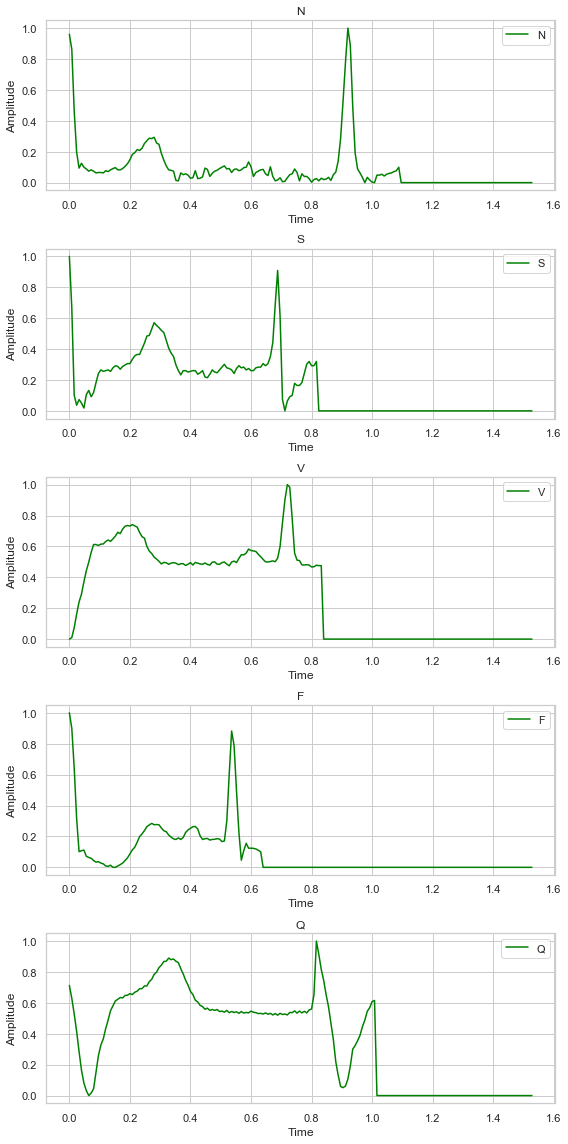

In [4]:
train_X = train_df.values[:, :-1]
train_y = train_df.values[:, -1].astype(int)
test_X = test_df.values[:, :-1]
test_y = test_df.values[:, -1].astype(int)

train_X = np.concatenate([train_X, np.zeros((train_X.shape[0], 5))], axis=1)
test_X = np.concatenate([test_X, np.zeros((test_X.shape[0], 5))], axis=1)

train_y_onehot = np.zeros((train_X.shape[0], 5))
for i in range(train_X.shape[0]):
    train_y_onehot[i, train_y[i]] = 1
test_y_onehot = np.zeros((test_X.shape[0], 5))
for i in range(test_X.shape[0]):
    test_y_onehot[i, test_y[i]] = 1

x = np.arange(0, 192)*8/1000
classes = ['N', 'S', 'V', 'F', 'Q']

fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.plot(x, train_X[train_y==i, :][0], label=classes[i], color='green')
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.set_title(classes[i])
    ax.legend()
fig.tight_layout() 
plt.savefig('ecg_beats.png')

In [5]:
# ---Hyperparameters---
num_tta = 5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# ---Transforms---
## If needed.

# --- Dataset---
class TrainECGDataset(Dataset):
    ### In order to inherit Dataset, define __len__ and __getitem__!

    def __init__(self, train_X, train_y, transforms=None):
        super().__init__()
        self.X = train_X
        self.y = train_y
        self.transforms = transforms

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
        sequence = self.X[idx]
        if self.transforms is not None:
            sequence = self.transforms(sequence)
        sequence = torch.unsqueeze(torch.from_numpy(sequence).float(), 0)
        target = torch.tensor(self.y[idx]).long()

        return sequence, target



class TestECGDataset(Dataset):
    ### Implement TTA (Test Time Augmentation).

    def __init__(self, test_X, test_y, transforms=None, tta=num_tta):
        super().__init__()
        self.X = test_X
        self.y = test_y
        self.transforms = transforms
        self.tta = tta

    def __len__(self):
        return len(self.X) * self.tta

    def __getitem__(self, idx):
        new_idx = idx % len(self.X)
        sequence = self.X[new_idx]
        if self.transforms is not None:
            sequence = self.transforms(sequence)
        sequence = torch.unsqueeze(torch.from_numpy(sequence).float(), 0)
        target = torch.tensor(self.y[new_idx]).long()

        return sequence, target

# ---DataLoader---
## If needed.

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class BaseBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(BaseBlock, self).__init__()   
        self.deeppath = nn.Sequential(
                                      nn.BatchNorm1d(in_channels),
                                      nn.PReLU(),
                                      nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                                      nn.BatchNorm1d(out_channels),
                                      nn.PReLU(),
                                      nn.Dropout(p=0.2, inplace=True),
                                      nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
                                     )
        self.shortcut = nn.Sequential(
                                      nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                      nn.BatchNorm1d(out_channels),
                                      nn.MaxPool1d(kernel_size=2)
                                     )

    def forward(self, x):
      dp = self.deeppath(x)
      sc = self.shortcut(x)
      return dp + sc


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


class ECGResNet(nn.Module):

    def __init__(self, block, num_classes=5):
        super(ECGResNet, self).__init__()
        self.net = nn.Sequential(
                                 nn.Conv1d(1, 16, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm1d(16),
                                 nn.PReLU(),
                                 nn.Conv1d(16, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm1d(64),
                                 nn.PReLU(),
                                 nn.Dropout(p=0.2, inplace=True),
                                 nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                 block(64, 128),
                                 nn.BatchNorm1d(128),
                                 nn.PReLU(),
                                 Flatten(),
                                 nn.Linear(128 * 24, num_classes)
                                )

    def forward(self, x):
        return self.net(x)


model = ECGResNet(BaseBlock).to(device)
model.apply(weights_init)

ECGResNet(
  (net): Sequential(
    (0): Conv1d(1, 16, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv1d(16, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Dropout(p=0.2, inplace=True)
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (8): BaseBlock(
      (deeppath): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): PReLU(num_parameters=1)
        (2): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
        (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): PReLU(num_parameters=1)
        (5): Dropout(p=0.2, inplace=True)
     

In [7]:
lr = 0.01
num_epochs = 50
batch_size=128

softmax = nn.Softmax()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
schedular = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True)

train_losses = []
test_losses =[]
train_f1s = []
test_f1s = []

train_preds = []
test_preds = []

best_model_wts = copy.deepcopy(model.state_dict())
best_f1 = 0
best_probs = None
best_preds = None

datasets = {
    'train': TrainECGDataset(train_X, train_y),
    'test': TestECGDataset(test_X, test_y)
}


dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(datasets['test'], batch_size=batch_size, shuffle=False)
}

# ---Training and Evaluation---
start_time = time.time()

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 20)

    for phase in ['test', 'train']:
        # 訓練無しでの性能を調べたいので先にテストセットの評価
        running_loss = 0 # of train or test
        epoch_loss = 0
        epoch_train_f1 = 0
        epoch_test_f1 = 0
        epoch_probs = None
        epoch_preds = None
        labels_list = None

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) 
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            _, preds = torch.max(outputs, 1)
            probs = softmax(outputs).detach().cpu().numpy()
            preds = preds.detach().cpu().numpy()
            labels = labels.cpu().numpy()
            if epoch_probs is None:
                epoch_probs = probs
                epoch_preds = preds
                epoch_labels = labels
            else:
                epoch_probs = np.concatenate([epoch_probs, probs])
                epoch_preds = np.concatenate([epoch_preds, preds])
                epoch_labels = np.concatenate([epoch_labels, labels])

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(datasets[phase])

        if phase == 'train':
            schedular.step(epoch_test_f1)
            train_losses.append(epoch_loss)
            epoch_train_preds = epoch_preds
            train_preds.append(epoch_train_preds)
            epoch_train_f1 = f1_score(epoch_labels, epoch_train_preds, average='macro')
            train_f1s.append(epoch_train_f1)
            print('{} | Loss: {} | F1: {}'.format(phase, epoch_loss, epoch_train_f1)) 
        else:
            test_losses.append(epoch_loss)
            tta_probs = np.zeros((int(len(datasets[phase]) / num_tta), 5))
            for i in range(num_tta):
                tta_probs += epoch_probs[int(len(datasets[phase]) / num_tta) * i:int(len(datasets[phase]) / num_tta) * (i + 1)]
            tta_probs /= num_tta
            tta_preds = np.argmax(tta_probs, axis=1)
            test_preds.append(tta_preds)
            epoch_test_f1 = f1_score(test_y, tta_preds, average='macro')
            test_f1s.append(epoch_test_f1)
            print('{} | Loss: {} | F1: {}'.format(phase, epoch_loss, epoch_test_f1))

            if epoch_test_f1 > best_f1:
                best_f1 = epoch_test_f1
                best_probs = tta_probs
                best_preds = tta_preds
                best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed  = time.time() - start_time
print('Training complete in {}m {}s.'.format(time_elapsed // 60, time_elapsed % 60))
print('Best f1: {}'.format(best_f1))

model.load_state_dict(best_model_wts)

Epoch 0/49
--------------------
test | Loss: 1.4536124000172046 | F1: 0.17834897400678865
train | Loss: 0.21364783534613926 | F1: 0.7631180984440289
Epoch 1/49
--------------------
test | Loss: 0.787074781736295 | F1: 0.626909997439817
train | Loss: 0.1252796875157251 | F1: 0.830042221371348
Epoch 2/49
--------------------
test | Loss: 0.10139637676745668 | F1: 0.8592130836662817
train | Loss: 0.08005263210666123 | F1: 0.8786101635179909
Epoch 3/49
--------------------
test | Loss: 0.08364404404811168 | F1: 0.8823226688424347
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
train | Loss: 0.07069718531485948 | F1: 0.893698786567527
Epoch 4/49
--------------------
test | Loss: 0.07564157084079652 | F1: 0.8853201459174566
train | Loss: 0.04735262258888847 | F1: 0.9221587968865996
Epoch 5/49
--------------------
test | Loss: 0.059005037380410415 | F1: 0.9062157687425403
train | Loss: 0.040400175761996976 | F1: 0.9308221118050902
Epoch 6/49
--------------------
test | Loss: 0.0

<All keys matched successfully>

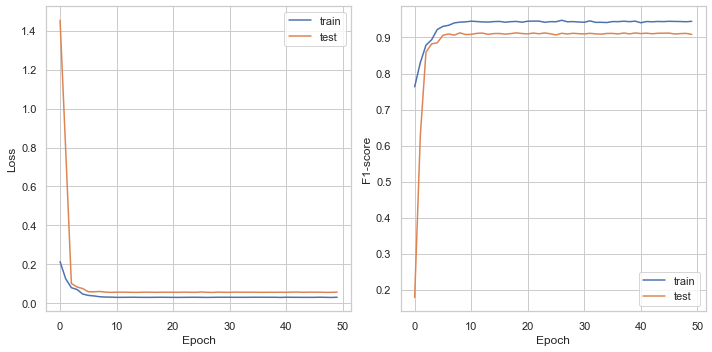

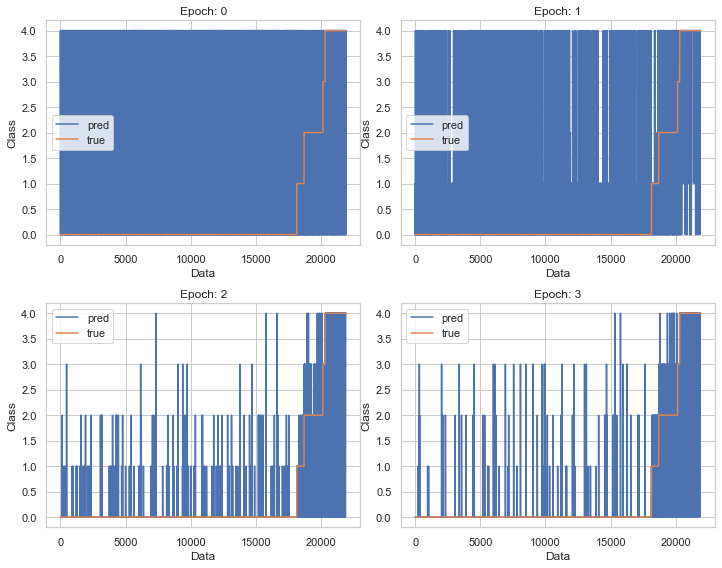

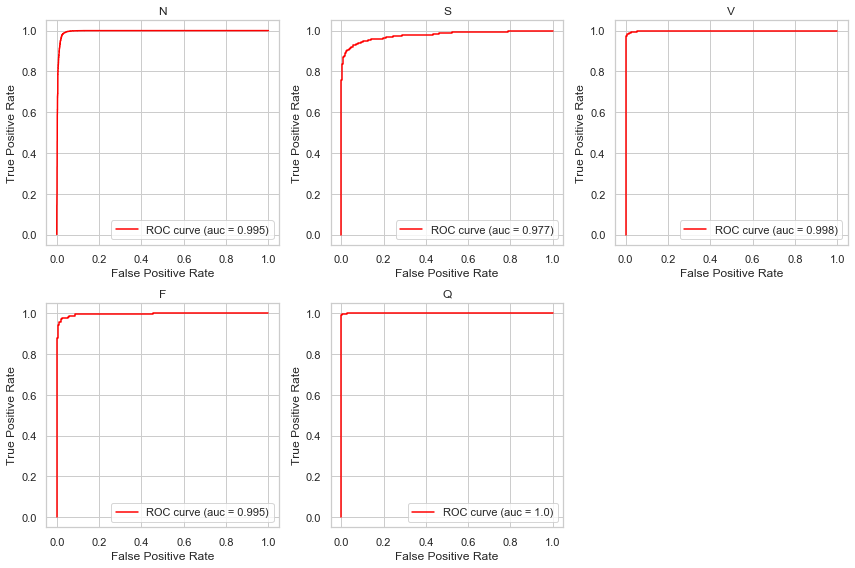

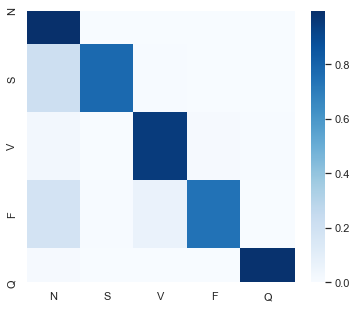

<Figure size 432x288 with 0 Axes>

In [10]:
#---Analysis---

## Loss and F1
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(train_losses, label='train')
ax1.plot(test_losses, label='test')
ax2.plot(train_f1s, label='train')
ax2.plot(test_f1s, label='test')
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("F1-score")
ax1.legend()
ax2.legend()
fig.tight_layout() 
plt.savefig('loss_f1.png')

## Prediction
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.plot(test_preds[i], label='pred') 
    ax.plot(test_y, label='true')
    ax.set_xlabel('Data')
    ax.set_ylabel('Class')
    ax.set_title('Epoch: {}'.format(str(i)))
    ax.legend()
fig.tight_layout() 
plt.savefig('test_classes.png')

## ROC
from sklearn.metrics import auc
classes = ['N', 'S', 'V', 'F', 'Q']

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    fpr, tpr, _ = roc_curve(test_y_onehot[:, i], tta_probs[:, i])
    score = round(auc(fpr, tpr), 3)
    ax.plot(fpr, tpr, label='ROC curve (auc = {})'.format(score), color='red')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(classes[i])
    ax.legend()
fig.tight_layout() 
plt.savefig('roc.png')

## Confusion matrix
cm = confusion_matrix(test_y, tta_preds)
cm = cm / np.sum(test_y_onehot, axis=0).reshape(-1, 1)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize = (6,5))
sns.heatmap(df_cm, cmap='Blues')
plt.show()
plt.savefig('confusion_matrix.png')  